In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.autograd import Variable

import numpy as np

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [2]:
import pandas as pd

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
X = pd.read_csv("processed_X.csv")
Y = pd.read_csv("processed_y.csv")
X = X.values
Y = Y.values

In [42]:
pd.read_csv("processed_y.csv").head()

,dec,mag_g_cModel,mag_i_cModel,mag_r_cModel,mag_u_cModel,mag_y_cModel,mag_z_cModel,ra
0,-0.959034,21.154710,19.056532,19.878065,23.599563,18.503124,18.661071,0.558005
1,-0.982055,18.760579,18.310800,18.446432,19.522369,18.380269,18.360969,0.464623
2,-0.921633,19.004927,17.967081,18.276592,20.572399,17.880807,17.932000,0.511996
3,-0.934786,24.266442,23.227235,23.430787,24.469184,23.565338,23.426335,0.519361
4,-0.972960,25.515661,24.374023,25.081538,25.618477,24.728155,25.318398,0.506802


In [5]:
class ConcreteDropout(nn.Module):
    def __init__(self, weight_regularizer=1e-6,
                 dropout_regularizer=1e-5, init_min=0.1, init_max=0.1):
        super(ConcreteDropout, self).__init__()

        
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        
        init_min = np.log(init_min) - np.log(1. - init_min)
        init_max = np.log(init_max) - np.log(1. - init_max)
        
        self.p_logit = nn.Parameter(torch.empty(1).uniform_(init_min, init_max))
        
    def forward(self, x, layer):
        p = torch.sigmoid(self.p_logit)
        
        out = layer(self._concrete_dropout(x, p))
        
        sum_of_square = 0
        for param in layer.parameters():
            sum_of_square += torch.sum(torch.pow(param, 2))
        
        weights_regularizer = self.weight_regularizer * sum_of_square / (1 - p)
        
        dropout_regularizer = p * torch.log(p)
        dropout_regularizer += (1. - p) * torch.log(1. - p)
        
        input_dimensionality = x[0].numel() # Number of elements of first item in batch
        dropout_regularizer *= self.dropout_regularizer * input_dimensionality
        
        regularization = weights_regularizer + dropout_regularizer
        return out, regularization
        
    def _concrete_dropout(self, x, p):
        eps = 1e-7
        temp = 0.1

        unif_noise = torch.rand_like(x)

        drop_prob = (torch.log(p + eps)
                    - torch.log(1 - p + eps)
                    + torch.log(unif_noise + eps)
                    - torch.log(1 - unif_noise + eps))
        
        drop_prob = torch.sigmoid(drop_prob / temp)
        random_tensor = 1 - drop_prob
        retain_prob = 1 - p
        
        x  = torch.mul(x, random_tensor)
        x /= retain_prob
        
        return x

In [6]:
class Model(nn.Module):
    def __init__(self, nb_features, weight_regularizer, dropout_regularizer):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(12, nb_features)
        self.linear2 = nn.Linear(nb_features, nb_features)
        self.linear3 = nn.Linear(nb_features, nb_features)

        self.linear4_mu = nn.Linear(nb_features, 8)
        self.linear4_logvar = nn.Linear(nb_features, 8)

        self.conc_drop1 = ConcreteDropout(weight_regularizer=weight_regularizer,
                                          dropout_regularizer=dropout_regularizer)
        self.conc_drop2 = ConcreteDropout(weight_regularizer=weight_regularizer,
                                          dropout_regularizer=dropout_regularizer)
        self.conc_drop3 = ConcreteDropout(weight_regularizer=weight_regularizer,
                                          dropout_regularizer=dropout_regularizer)
        self.conc_drop_mu = ConcreteDropout(weight_regularizer=weight_regularizer,
                                             dropout_regularizer=dropout_regularizer)
        self.conc_drop_logvar = ConcreteDropout(weight_regularizer=weight_regularizer,
                                                 dropout_regularizer=dropout_regularizer)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        regularization = torch.empty(5, device=x.device)
        
        x1, regularization[0] = self.conc_drop1(x, nn.Sequential(self.linear1, self.relu))
        x2, regularization[1] = self.conc_drop2(x1, nn.Sequential(self.linear2, self.relu))
        x3, regularization[2] = self.conc_drop3(x2, nn.Sequential(self.linear3, self.relu))

        mean, regularization[3] = self.conc_drop_mu(x3, self.linear4_mu)
        log_var, regularization[4] = self.conc_drop_logvar(x3, self.linear4_logvar)

        return mean, log_var, regularization.sum()

def heteroscedastic_loss(true, mean, log_var):
    precision = torch.exp(-log_var)
    return torch.mean(torch.sum(precision * (true - mean)**2 + log_var, 1), 0)

In [7]:
N = 10262 # Number of data points
nb_epoch = 20
nb_val_size = 1283 # Validation size
nb_features = 1024 # Hidden layer size
Q = 12 # Data dimensionality
D = 8 # One mean, one log_var
K_test = 20 # Number of MC samples
nb_reps = 3 # Number of times to repeat experiment
batch_size = 20
l = 1e-4 # Lengthscale

In [8]:
def fit_model(nb_epoch, X, Y):
    N = X.shape[0]
    wr = l**2. / N
    dr = 2. / N
    model = Model(nb_features, wr, dr)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters())
    
    for i in range(nb_epoch):
        old_batch = 0
        for batch in range(int(np.ceil(X.shape[0]/batch_size))):
            batch = (batch + 1)
            _x = X[old_batch: batch_size*batch]
            _y = Y[old_batch: batch_size*batch]
            
            x = Variable(torch.FloatTensor(_x)).to(device)
            y = Variable(torch.FloatTensor(_y)).to(device)
            
            mean, log_var, regularization = model(x)
                        
            loss = heteroscedastic_loss(y, mean, log_var) + regularization
             
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    return model

In [9]:
def logsumexp(a):
    a_max = a.max(axis=0)
    return np.log(np.sum(np.exp(a - a_max), axis=0)) + a_max

def test(Y_true, K_test, means, logvar):
    """
    Estimate predictive log likelihood:
    log p(y|x, D) = log int p(y|x, w) p(w|D) dw
                 ~= log int p(y|x, w) q(w) dw
                 ~= log 1/K sum p(y|x, w_k) with w_k sim q(w)
                  = LogSumExp log p(y|x, w_k) - log K
    :Y_true: a 2D array of size N x dim
    :MC_samples: a 3D array of size samples K x N x 2*D
    """
    k = K_test
    N = Y_true.shape[0]
    mean = means 
    logvar = logvar
    test_ll = -0.5 * np.exp(-logvar) * (mean - Y_val.squeeze())**2. - 0.5 * logvar - 0.5 * np.log(2 * np.pi) #Y_true[None]
    test_ll = np.sum(np.sum(test_ll, -1), -1)
    test_ll = logsumexp(test_ll) - np.log(k)
    pppp = test_ll / N  # per point predictive probability
    rmse = np.mean((np.mean(mean, 0) - Y_val.squeeze())**2.)**0.5
    return pppp, rmse

In [31]:
np.argsort(X_val[:, 0]), X_val.shape, np.mean(means, 0).shape, means.shape

(array([  96,   80,  445, ..., 1735, 1742, 1780]),
 (2566, 12),
 (2566, 8),
 (20, 2566, 8))

In [38]:
def plot(X_train, Y_train, X_val, Y_val, means, param):
    # means ~ [K_test, data_size, num_params]
    # Number of repeated sampling
    K_test = means.shape[0]
    indx = np.argsort(X_val[:, param]) # plt.plot requires x-ordered points
    _, (ax1, ax2, ax3, ax4) = pylab.subplots(1, 4,figsize=(12, 1.5), sharex=True, sharey=True)
    # 1. Show just the train set
    ax1.scatter(X_train[:, param], Y_train[:, param], c='y')
    ax1.set_title('Train set')
    # 1 overlaid with 2. Show predicted means (averaged across samples) for validation set
    ax2.plot(X_val[indx, param], np.mean(means, 0)[indx, param], color='skyblue', lw=3)
    ax2.scatter(X_train[:, param], Y_train[:, 0], c='y')
    ax2.set_title('+Predictive mean')
    # 2 overlaid with 3. All predicted means across samples (not averaged) for validation set
    for i in range(K_test):
        ax3.scatter(X_val[:, param], means[i, :, param], c='b', alpha=0.2, lw=0)
    ax3.plot(X_val[indx, param], np.mean(means, 0)[indx, param], color='skyblue', lw=3)
    ax3.set_title('+MC samples on validation X')
    # Just the validation set
    ax4.scatter(X_val[:, param], Y_val[:, param], c='r', alpha=0.2, lw=0)
    ax4.set_title('Validation set')
    
    pylab.show()

In [11]:
#X, Y = gen_data(N + nb_val_size)
X_train, Y_train = X[:N], Y[:N]
X_val, Y_val = X[N:], Y[N:]

In [12]:
model = fit_model(nb_epoch, X_train, Y_train)
model.eval()

Model(
  (linear1): Linear(in_features=12, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=1024, bias=True)
  (linear4_mu): Linear(in_features=1024, out_features=8, bias=True)
  (linear4_logvar): Linear(in_features=1024, out_features=8, bias=True)
  (conc_drop1): ConcreteDropout()
  (conc_drop2): ConcreteDropout()
  (conc_drop3): ConcreteDropout()
  (conc_drop_mu): ConcreteDropout()
  (conc_drop_logvar): ConcreteDropout()
  (relu): ReLU()
)

In [13]:
MC_samples = [model(Variable(torch.FloatTensor(X_val)).to(device)) for _ in range(K_test)]

RuntimeError: invalid argument 2: size '[20 x 2566]' is invalid for input with 410560 elements at /opt/conda/conda-bld/pytorch_1533672544752/work/aten/src/TH/THStorage.cpp:84

In [23]:
MC_samples[0][0].shape, len(MC_samples), X_val.shape[0]

(torch.Size([2566, 8]), 20, 2566)

In [24]:
torch.stack([tup[0] for tup in MC_samples]).shape

torch.Size([20, 2566, 8])

In [21]:
import pylab

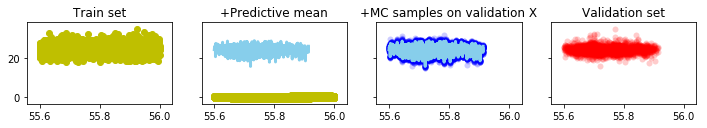

In [61]:
means = torch.stack([tup[0] for tup in MC_samples]).view(K_test, X_val.shape[0], D).cpu().data.numpy()
logvar = torch.stack([tup[1] for tup in MC_samples]).view(K_test, X_val.shape[0], D).cpu().data.numpy()
pppp, rmse = test(Y_val, K_test, means, logvar)
param = 4
epistemic_uncertainty = np.var(means, 0).mean(0)[param]
#logvar = np.mean(logvar, 0)[param]
aleatoric_uncertainty = np.exp(logvar).mean(0)
ps = np.array([torch.sigmoid(module.p_logit).cpu().data.numpy()[0] for module in model.modules() if hasattr(module, 'p_logit')])
plot(X_train, Y_train, X_val, Y_val, means, param=param)

In [63]:
np.save("means", means.reshape(20, -1))
np.save("logvar", logvar.reshape(20, -1))

In [62]:
logvar.shape

(20, 2566, 8)

In [45]:
np.mean(logvar, 0).shape

(8,)